In [2]:
import findspark
findspark.init()

from pyspark import SparkContext
sc=SparkContext(master="local[4]")

from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint

from string import split,strip

from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.tree import RandomForest, RandomForestModel

from pyspark.mllib.util import MLUtils

### Higgs data set
* **URL:** http://archive.ics.uci.edu/ml/datasets/HIGGS#  
* **Abstract:** This is a classification problem to distinguish between a signal process which produces Higgs bosons and a background process which does not.

**Data Set Information:**  
The data has been produced using Monte Carlo simulations. The first 21 features (columns 2-22) are kinematic properties measured by the particle detectors in the accelerator. The last seven features are functions of the first 21 features; these are high-level features derived by physicists to help discriminate between the two classes. There is an interest in using deep learning methods to obviate the need for physicists to manually develop such features. Benchmark results using Bayesian Decision Trees from a standard physics package and 5-layer neural networks are presented in the original paper. The last 500,000 examples are used as a test set.



In [3]:
#define feature names
feature_text='lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb'
features=[strip(a) for a in split(feature_text,',')]
print len(features),features

28 ['lepton pT', 'lepton eta', 'lepton phi', 'missing energy magnitude', 'missing energy phi', 'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag', 'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 eta', 'jet 4 phi', 'jet 4 b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']


In [4]:
# create a directory called higgs, download and decompress HIGGS.csv.gz into it

from os.path import exists
if not exists('higgs'):
    print "creating directory higgs"
    !mkdir higgs
%cd higgs
if not exists('HIGGS.csv'):
    if not exists('HIGGS.csv.gz'):
        print 'downloading HIGGS.csv.gz'
        !curl -O http://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
    print 'decompressing HIGGS.csv.gz --- May take 5-10 minutes'
    !gunzip -f HIGGS.csv.gz
!ls -l
%cd ..

/home/ojas/Desktop/UCSD/cse255/Classes/HW-7/higgs
total 7847172
-rw-rw-r-- 1 ojas ojas 8035497980 Jun  2 16:51 HIGGS.csv
/home/ojas/Desktop/UCSD/cse255/Classes/HW-7


### As done in previous notebook, create RDDs from raw data and build Gradient boosting and Random forests models. Consider doing 1% sampling since the dataset is too big for your local machine

In [5]:
# Read the file into an RDD
# If doing this on a real cluster, you need the file to be available on all nodes, ideally in HDFS.
path='higgs/HIGGS.csv'
inputRDD = sc.textFile(path)
inputRDD.first()

u'1.000000000000000000e+00,8.692932128906250000e-01,-6.350818276405334473e-01,2.256902605295181274e-01,3.274700641632080078e-01,-6.899932026863098145e-01,7.542022466659545898e-01,-2.485731393098831177e-01,-1.092063903808593750e+00,0.000000000000000000e+00,1.374992132186889648e+00,-6.536741852760314941e-01,9.303491115570068359e-01,1.107436060905456543e+00,1.138904333114624023e+00,-1.578198313713073730e+00,-1.046985387802124023e+00,0.000000000000000000e+00,6.579295396804809570e-01,-1.045456994324922562e-02,-4.576716944575309753e-02,3.101961374282836914e+00,1.353760004043579102e+00,9.795631170272827148e-01,9.780761599540710449e-01,9.200048446655273438e-01,7.216574549674987793e-01,9.887509346008300781e-01,8.766783475875854492e-01'

In [ ]:
# Transform the text RDD into an RDD of LabeledPoints
Data=inputRDD.map(lambda line: [float(strip(x)) for x in line.split(',')]).map(lambda x: LabeledPoint(x[0], x[1:])).cache()
Data.first()
# LabeledPoint(5.0, [2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])

LabeledPoint(1.0, [0.869293212891,-0.635081827641,0.22569026053,0.327470064163,-0.689993202686,0.754202246666,-0.24857313931,-1.09206390381,0.0,1.37499213219,-0.653674185276,0.930349111557,1.10743606091,1.13890433311,-1.57819831371,-1.0469853878,0.0,0.65792953968,-0.0104545699432,-0.0457671694458,3.10196137428,1.35376000404,0.979563117027,0.978076159954,0.920004844666,0.721657454967,0.988750934601,0.876678347588])

In [ ]:
Data1=Data.sample(False,0.01).cache()
(trainingData,testData)=Data1.randomSplit([0.7,0.3])

print 'Sizes: Data1=%d, trainingData=%d, testData=%d'%(Data1.count(),trainingData.cache().count(),testData.cache().count())

### Gradient Boosted Trees

* Following [this example](http://spark.apache.org/docs/latest/mllib-ensembles.html#gradient-boosted-trees-gbts) from the mllib documentation

* [pyspark.mllib.tree.GradientBoostedTrees documentation](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.tree.GradientBoostedTrees)

#### Main classes and methods

* `GradientBoostedTrees` is the class that implements the learning trainClassifier,
   * It's main method is `trainClassifier(trainingData)` which takes as input a training set and generates an instance of `GradientBoostedTreesModel`
   * The main parameter from train Classifier are:
      * **data** – Training dataset: RDD of LabeledPoint. Labels should take values {0, 1}.
      * categoricalFeaturesInfo – Map storing arity of categorical features. E.g., an entry (n -> k) indicates that feature n is categorical with k categories indexed from 0: {0, 1, ..., k-1}.
      * **loss** – Loss function used for minimization during gradient boosting. Supported: {“logLoss” (default), “leastSquaresError”, “leastAbsoluteError”}.
      * **numIterations** – Number of iterations of boosting. (default: 100)
      * **learningRate** – Learning rate for shrinking the contribution of each estimator. The learning rate should be between in the interval (0, 1]. (default: 0.1)
      * **maxDepth** – Maximum depth of the tree. E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. (default: 3)
      * **maxBins** – maximum number of bins used for splitting features (default: 32) DecisionTree requires maxBins >= max categories
      
      
* `GradientBoostedTreesModel` represents the output of the boosting process: a linear combination of classification trees. The methods supported by this class are:
   * `save(sc, path)` : save the tree to a given filename, sc is the Spark Context.
   * `load(sc,path)` : The counterpart to save - load classifier from file.
   * `predict(X)` : predict on a single datapoint (the `.features` field of a `LabeledPont`) or an RDD of datapoints.
   * `toDebugString()` : print the classifier in a human readable format.

In [16]:
from time import time
errors={}
for depth in [1,3,6,10]:
    start=time()
    model=GradientBoostedTrees.trainClassifier(trainingData, {}, numIterations=10, maxDepth = depth)
#     print model.toDebugString()
    errors[depth]={}
    dataSets={'train':trainingData,'test':testData}
    for name in dataSets.keys():  # Calculate errors on train and test sets
        data=dataSets[name]
        Predicted=model.predict(data.map(lambda x: x.features))
        LabelsAndPredictions=data.map(lambda x: x.label).zip(Predicted)
        Err = LabelsAndPredictions.filter(lambda (v,p):v != p).count()/float(data.count())
        errors[depth][name]=Err
    print depth,errors[depth],int(time()-start),'seconds'
print errors

1 {'test': 0.3674143679903001, 'train': 0.36866723677731994} 3039 seconds
3 {'test': 0.3210366777811458, 'train': 0.32145170903625386} 1795 seconds
6 {'test': 0.30212185510760836, 'train': 0.29200031096944723} 2316 seconds
10 {'test': 0.30175810851773266, 'train': 0.19475757340174663} 3766 seconds
{1: {'test': 0.3674143679903001, 'train': 0.36866723677731994}, 10: {'test': 0.30175810851773266, 'train': 0.19475757340174663}, 3: {'test': 0.3210366777811458, 'train': 0.32145170903625386}, 6: {'test': 0.30212185510760836, 'train': 0.29200031096944723}}


In [17]:
B10 = errors

Populating the interactive namespace from numpy and matplotlib


/home/ojas/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['split']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


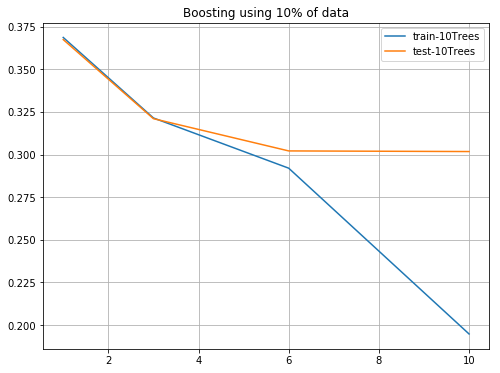

In [18]:
# Plot Train/test accuracy vs Depth of trees graph
%pylab inline
from plot_utils import *
make_figure([B10],['10Trees'],Title='Boosting using 10% of data')

### Random Forests

* Following [this example](http://spark.apache.org/docs/latest/mllib-ensembles.html#classification) from the mllib documentation

* [pyspark.mllib.trees.RandomForest documentation](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.tree.RandomForest)

**trainClassifier**`(data, numClasses, categoricalFeaturesInfo, numTrees, featureSubsetStrategy='auto', impurity='gini', maxDepth=4, maxBins=32, seed=None)`   
Method to train a decision tree model for binary or multiclass classification.

**Parameters:**  
* *data* – Training dataset: RDD of LabeledPoint. Labels should take values {0, 1, ..., numClasses-1}.  
* *numClasses* – number of classes for classification.  
* *categoricalFeaturesInfo* – Map storing arity of categorical features. E.g., an entry (n -> k) indicates that feature n is categorical with k categories indexed from 0: {0, 1, ..., k-1}.  
* *numTrees* – Number of trees in the random forest.  
* *featureSubsetStrategy* – Number of features to consider for splits at each node. Supported: “auto” (default), “all”, “sqrt”, “log2”, “onethird”. If “auto” is set, this parameter is set based on numTrees: if numTrees == 1, set to “all”; if numTrees > 1 (forest) set to “sqrt”.
* *impurity* – Criterion used for information gain calculation. Supported values: “gini” (recommended) or “entropy”.  
* *maxDepth* – Maximum depth of the tree. E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. (default: 4)  
* *maxBins* – maximum number of bins used for splitting features (default: 32)
* *seed* – Random seed for bootstrapping and choosing feature subsets.  

**Returns:**	
RandomForestModel that can be used for prediction

In [19]:
from time import time
errors={}
for depth in [1,3,6,10,15,20]:
    start=time()
    model = RandomForest.trainClassifier(trainingData, 2, {}, 10, maxDepth = depth)
    #print model.toDebugString()
    errors[depth]={}
    dataSets={'train':trainingData,'test':testData}
    for name in dataSets.keys():  # Calculate errors on train and test sets
        data=dataSets[name]
        Predicted=model.predict(data.map(lambda x: x.features))
        LabelsAndPredictions=data.map(lambda x: x.label).zip(Predicted)
        Err = LabelsAndPredictions.filter(lambda (v,p):v != p).count()/float(data.count())
        errors[depth][name]=Err
    print depth,errors[depth],int(time()-start),'seconds'
print errors

1 {'test': 0.4184298272203698, 'train': 0.4188110601466739} 2323 seconds


KeyboardInterrupt: 

In [ ]:
RF_10trees = errors
# Plot Train/test accuracy vs Depth of trees graph
make_figure([RF_10trees],['10Trees'],Title='Random Forests using 10% of data')

In [ ]:
fig = [RF_10trees, B10]
make_figure(fig,['RF_10trees','10Trees'],Title='Random Forests using 10% of data')

In [20]:
sc.stop()